# Importing Libraries

In [ ]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from collections import Counter
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier
from textblob.classifiers import DecisionTreeClassifier
import scipy.stats
import sklearn.linear_model
import sklearn.discriminant_analysis
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.neighbors
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import sklearn.linear_model as lm
from sklearn import metrics
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
!pip install swifter
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 13.3 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=086c7297389b7e41f2f1bc9f682379be887d7fa8d3a98b6fb009ab07ead6fdc9
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: f

In [ ]:
# Hide annoying pandas warning
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Importing Data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("crowdflower/political-social-media-posts")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/crowdflower/political-social-media-posts/versions/1


In [ ]:

!pip install kaggle
from google.colab import files

# Upload your kaggle.json file
files.upload()

# Move kaggle.json to the Kaggle directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Replace 'crowdflower/political-social-media-posts' with the Kaggle dataset name
!kaggle datasets download -d crowdflower/political-social-media-posts

# Unzip the dataset
!unzip political-social-media-posts.zip

Dataset URL: https://www.kaggle.com/datasets/crowdflower/political-social-media-posts
License(s): CC0-1.0
political-social-media-posts.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  political-social-media-posts.zip
replace political_social_media.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Reading in csv
text_df = pd.read_csv("political_social_media.csv", encoding='ISO-8859-1')
text_df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,audience,audience:confidence,bias,bias:confidence,message,...,orig__golden,audience_gold,bias_gold,bioid,embed,id,label,message_gold,source,text
0,766192484,False,finalized,1,8/4/15 21:17,national,1.0,partisan,1.0,policy,...,NaN,NaN,NaN,R000596,"<blockquote class=""twitter-tweet"" width=""450"">...",3.83249E+17,From: Trey Radel (Representative from Florida),NaN,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,766192485,False,finalized,1,8/4/15 21:20,national,1.0,partisan,1.0,attack,...,NaN,NaN,NaN,M000355,"<blockquote class=""twitter-tweet"" width=""450"">...",3.11208E+17,From: Mitch McConnell (Senator from Kentucky),NaN,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...
2,766192486,False,finalized,1,8/4/15 21:14,national,1.0,neutral,1.0,support,...,NaN,NaN,NaN,S001180,"<blockquote class=""twitter-tweet"" width=""450"">...",3.39069E+17,From: Kurt Schrader (Representative from Oregon),NaN,twitter,Please join me today in remembering our fallen...
3,766192487,False,finalized,1,8/4/15 21:08,national,1.0,neutral,1.0,policy,...,NaN,NaN,NaN,C000880,"<blockquote class=""twitter-tweet"" width=""450"">...",2.98528E+17,From: Michael Crapo (Senator from Idaho),NaN,twitter,RT @SenatorLeahy: 1st step toward Senate debat...
4,766192488,False,finalized,1,8/4/15 21:26,national,1.0,partisan,1.0,policy,...,NaN,NaN,NaN,U000038,"<blockquote class=""twitter-tweet"" width=""450"">...",4.07643E+17,From: Mark Udall (Senator from Colorado),NaN,twitter,.@amazon delivery #drones show need to update ...


# Cleaning Data

In [ ]:
# Making a copy of the df incase needing to revert back due to error
clean_df = text_df.copy()

In [ ]:
 Remove columns to keep only those subject to analysis
clean_df = text_df[['_unit_id', 'text', 'label', 'bias', 'message']]
clean_df.head()

,_unit_id,text,label,bias,message
0,766192484,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,From: Trey Radel (Representative from Florida),partisan,policy
1,766192485,VIDEO - #Obamacare: Full of Higher Costs and ...,From: Mitch McConnell (Senator from Kentucky),partisan,attack
2,766192486,Please join me today in remembering our fallen...,From: Kurt Schrader (Representative from Oregon),neutral,support
3,766192487,RT @SenatorLeahy: 1st step toward Senate debat...,From: Michael Crapo (Senator from Idaho),neutral,policy
4,766192488,.@amazon delivery #drones show need to update ...,From: Mark Udall (Senator from Colorado),partisan,policy


In [ ]:
# --- Converting to lowercase ---

# Preserve 'US' by replacing it with a placeholder
clean_df.loc[:, 'text'] = clean_df['text'].str.replace(r'\bUS\b', 'PLACEHOLDER_US', regex=True)

# Convert all text to lowercase for standardization
clean_df.loc[:, 'text'] = clean_df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Restore 'US' from the placeholder
clean_df.loc[:, 'text'] = clean_df['text'].str.replace('placeholder_us', 'US', regex=False)

# Display cleaned text
clean_df['text'].head()

,text
0,rt @nowthisnews: rep. trey radel (r- #fl) slam...
1,video - #obamacare: full of higher costs and b...
2,please join me today in remembering our fallen...
3,rt @senatorleahy: 1st step toward senate debat...
4,.@amazon delivery #drones show need to update ...


In [ ]:
import re  # "regular expressions" very useful for parsing text, looking for patterns, etc.

# Define unwanted characters and patterns
to_remove = [
    r'@\S+', # Matches @username
    r'[^\w\s]',  # Non-word characters except spaces
    r'#', r'-', r'"', r';', r':', r'%', r'\^', r'&', r'\*', r',', r'fl', r'ª', r'û',r'ò'  # Specific symbols
    r'&amp;', r'\bamp\b',  # HTML entities
    r'\brt\b',  # Matches 'rt' as a standalone word
    r'http\S+'  # Matches http links
]

# Clean the text
for pattern in to_remove:
    clean_df.loc[:, 'text'] = clean_df['text'].str.replace(pattern, '', regex=True)

# sometimes in the text there were random ' r ' characters so i had to remove those manually
clean_df.loc[:, 'text'] = clean_df['text'].str.replace(r'\s+r\s+', ' ', regex=True)

# Remove extra spaces
clean_df.loc[:, 'text'] = clean_df['text'].str.strip().str.replace(r'\s+', ' ', regex=True)

# Display cleaned text
clean_df.loc[:, 'text']


,text
0,rep trey radel slams obamacare politics
1,video obamacare full of higher costs and broke...
2,please join me today in remembering our fallen...
3,1st step toward senate debate on leahycrapo va...
4,delivery drones show need to update law to pro...
...,...
4995,i applaud governor perrys recent decision to d...
4996,today i voted in favor of hr 5016 financial se...
4997,taken from posted wokv interview congressman y...
4998,join me next week for a town hall in ocala ill...


In [ ]:
# Remove filler words such as "and," "the," "is" that are generally considered irrelevant for NLP.
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = stopwords.words('english')
clean_df.loc[:, 'text'] = clean_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
clean_df['text']

,text
0,rep trey radel slams obamacare politics
1,video obamacare full higher costs broken promises
2,please join today remembering fallen heroes ho...
3,1st step toward senate debate leahycrapo vawa ...
4,delivery drones show need update law promote i...
...,...
4995,applaud governor perrys recent decision deploy...
4996,today voted favor hr 5016 financial services g...
4997,taken posted wokv interview congressman yoho s...
4998,join next week town hall ocala ill answer ques...


In [ ]:
freq = pd.Series(' '.join(clean_df['text']).split()).value_counts()
#freq[-20:] #least common words
#freq[:20] #most common words
freq

,count
today,715
house,434
great,395
us,371
new,361
...,...
rockchalk,1
redistricting,1
yoder,1
distinct,1


In [ ]:
# Optional/Not Implemented - remove less frequent words to reduce vocabulary clutter. This step can help ml model train quicker, and or improve accuracy.
# But it may not be smart because our dataset is relatively small, and removing these small words may throw out important contextual data.
# Also, Roberta is capable of tokenizing uncommon words in a way that extracts use out of them regardless.

Spell correction using FastText library and Swifter library.
1. Swifter is a parallel computing library that is well optimized for pandas
.apply() function. Not entirely useful for this small dataset but could save time with larger ones.
2. FastText is context-aware, meaning it can infer spelling corrections even for out-of-vocabulary words by breaking them down into subword units.
Best for applications requiring a more flexible and adaptable correction system, such as analyzing user-generated content.

In [ ]:
# Download pre-trained FastText model (English wiki)
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

--2025-02-02 09:07:58--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.15, 13.226.210.78, 13.226.210.111, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘lid.176.bin’

lid.176.bin         100%[===================>] 125.18M   114MB/s    in 1.1s    

2025-02-02 09:07:59 (114 MB/s) - ‘lid.176.bin’ saved [131266198/131266198]



In [ ]:
import swifter
import fasttext


def fasttext_correct(text):
    corrected_text = []
    for word in text.split():
        prediction = model.predict(word)  # Predict language and confidence
        if prediction[1][0] > 0.5:
            corrected_text.append(word)
        else:
            # Use FastText to suggest similar words
            similar_words = model.get_nearest_neighbors(word)
            if similar_words:
                corrected_text.append(similar_words[0][1])  # Choose closest match
            else:
                corrected_text.append(word)  # Keep the original if no match found
    return ' '.join(corrected_text)


In [ ]:
# Apply spelling correction to the DataFrame
clean_df['text'] = clean_df['text'].swifter.apply(fasttext_correct)

NameError: name 'model' is not defined

In [ ]:
#TODO: Drop rows where there is no TEXT variable

# Pre ML EDA

In [ ]:
eda_df = clean_df

Prepare Bias and Message Columns to Categorical


In [ ]:
# Convert the bias and message columns to categorical (this will be helpful for classification methods later on)
eda_df.bias = pd.Categorical(eda_df.bias)
eda_df.message = pd.Categorical(eda_df.message)

Create a "vector" column with vectorized "text" field.

In [ ]:
eda_df['vector'] = [i for i in eda_df.text.str.split(" ")]

In [ ]:
# Let's now look at the first 10 rows (capitalized column headers)
eda_df.bias = pd.Categorical(eda_df.bias)
renameColumns = {'bias' : 'BIAS', 'message' : 'MESSAGE', 'label' : 'LABEL', 'text' : 'TEXT', 'vector' : 'VECTOR'}
eda_df.rename(mapper = renameColumns, axis = 1, inplace=True)
eda_df.head(10)

,_unit_id,TEXT,LABEL,BIAS,MESSAGE,VECTOR
0,766192484,rep trey radel slams obamacare politics,From: Trey Radel (Representative from Florida),partisan,policy,"[rep, trey, radel, slams, obamacare, politics]"
1,766192485,video obamacare full higher costs broken promises,From: Mitch McConnell (Senator from Kentucky),partisan,attack,"[video, obamacare, full, higher, costs, broken..."
2,766192486,please join today remembering fallen heroes ho...,From: Kurt Schrader (Representative from Oregon),neutral,support,"[please, join, today, remembering, fallen, her..."
3,766192487,1st step toward senate debate leahycrapo vawa ...,From: Michael Crapo (Senator from Idaho),neutral,policy,"[1st, step, toward, senate, debate, leahycrapo..."
4,766192488,delivery drones show need update law promote i...,From: Mark Udall (Senator from Colorado),partisan,policy,"[delivery, drones, show, need, update, law, pr..."
5,766192489,called release info inspections casseltonderai...,From: Heidi Heitkamp (Senator from North Dakota),partisan,information,"[called, release, info, inspections, casselton..."
6,766192490,help us keep kidnapped nigerian school girls s...,From: Frederica Wilson (Representative from Fl...,neutral,mobilization,"[help, us, keep, kidnapped, nigerian, school, ..."
7,766192491,show arizona pridechoose favorite az picture f...,From: Ron Barber (Representative from Arizona),neutral,mobilization,"[show, arizona, pridechoose, favorite, az, pic..."
8,766192492,wonderful night state senator ken yagers chili...,From: Chuck Fleischmann (Representative from T...,neutral,personal,"[wonderful, night, state, senator, ken, yagers..."
9,766192493,great oped pres clinton signing fmla 20 yrs ag...,From: Steny Hoyer (Representative from Maryland),partisan,support,"[great, oped, pres, clinton, signing, fmla, 20..."


In [ ]:
#Again let's look at the type of values for the remaining columns
for column in eda_df.columns:
    print("%s       \t# of unique values: %s,   \tdtype: %s" % (column, len(np.unique(eda_df[column].values)), eda_df[column].dtype))

_unit_id       	# of unique values: 5000,   	dtype: int64
TEXT       	# of unique values: 4979,   	dtype: object
LABEL       	# of unique values: 505,   	dtype: object
BIAS       	# of unique values: 2,   	dtype: category
MESSAGE       	# of unique values: 9,   	dtype: category
VECTOR       	# of unique values: 4979,   	dtype: object


In [ ]:
print("There are {} observations and {} features in this dataset. \n".format(eda_df.shape[0],eda_df.shape[1]))

There are 5000 observations and 6 features in this dataset. 



In [ ]:
count_words = Counter()
eda_df.VECTOR.apply(count_words.update)
print('MOST COMMON WORD (COUNT):\n', count_words.most_common(50))
print('\n\n')
print('LEAST COMMON WORD (COUNT):\n', count_words.most_common()[-250:-200])

MOST COMMON WORD (COUNT):
 [('today', 715), ('house', 434), ('great', 395), ('us', 371), ('new', 361), ('bill', 324), ('act', 296), ('congress', 292), ('veterans', 290), ('president', 286), ('day', 286), ('work', 275), ('time', 267), ('help', 261), ('health', 257), ('jobs', 242), ('people', 237), ('state', 234), ('care', 224), ('american', 223), ('government', 221), ('obamacare', 217), ('americans', 216), ('need', 212), ('one', 211), ('support', 208), ('service', 205), ('senate', 205), ('week', 202), ('year', 200), ('would', 196), ('families', 192), ('thanks', 192), ('law', 189), ('office', 186), ('national', 185), ('federal', 184), ('make', 183), ('read', 179), ('im', 178), ('get', 176), ('first', 168), ('like', 167), ('obama', 166), ('last', 164), ('morning', 163), ('years', 162), ('proud', 161), ('must', 160), ('community', 158)]



LEAST COMMON WORD (COUNT):
 [('westmetro', 1), ('kathleen', 1), ('richland', 1), ('orangeburg', 1), ('tolar', 1), ('westmorelandscoverphoto', 1), ('warw

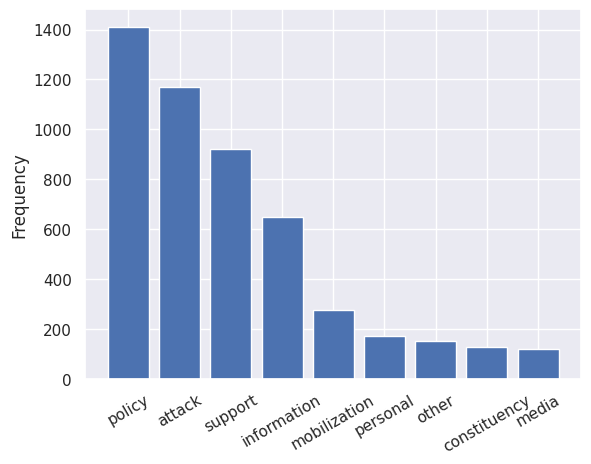

In [ ]:
x = eda_df.MESSAGE.unique()
y = eda_df.MESSAGE.value_counts()
plt.bar(x, y);
plt.xticks(rotation=30);
plt.ylabel('Frequency');

In [ ]:
print("Total Messages:\n",eda_df.MESSAGE.describe())
print("\nBiased word choices:\n",eda_df.BIAS.describe())

Total Messages:
 count       5000
unique         9
top       policy
freq        1411
Name: MESSAGE, dtype: object

Biased word choices:
 count        5000
unique          2
top       neutral
freq         3689
Name: BIAS, dtype: object


In [ ]:
data = eda_df['LABEL'].iloc[:]
states = data.groupby(eda_df['LABEL']).count()
states.sort_values(ascending=False)

,LABEL
LABEL,
From: Ileana Ros-Lehtinen (Representative from Florida),79
From: Kevin Brady (Representative from Texas),69
From: Cory Booker (Senator from New Jersey),49
From: John Fleming (Representative from Louisiana),48
From: Bernard Sanders (Senator from Vermont),40
...,...
From: Trent Franks (Representative from Arizona),1
From: Jim Matheson (Representative from Utah),1
From: William Cowan (Senator from Massachusetts),1


In [ ]:
ptext = " ".join(review for review in eda_df.TEXT)
print ("There are {} words in the combination of all tweets.".format(len(ptext)))

There are 671788 words in the combination of all tweets.


# Machine Learning

So right now, we want to train a model to predict one of 3 bias categories for each tweet. **Left, right, and neutral**. The problem is, the current dataset we are using only has 2 categories; **neutral and partisan**. This don't work unc!!!!!! Im gonna try to reclassify the data somehow.

Testing k means clustering to seperate text into 'left' 'neutral' and 'right' bias categories. This prob wont work lol


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from wordcloud import WordCloud

In [ ]:
ml_df = eda_df

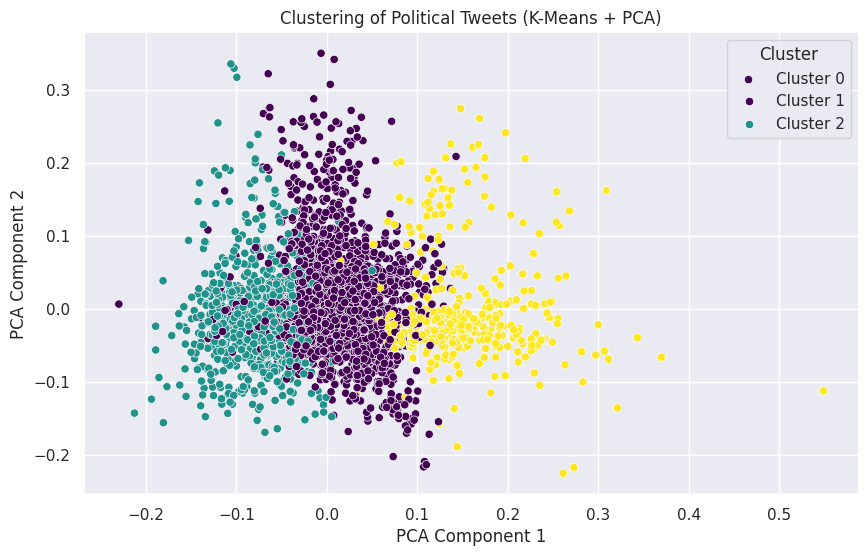

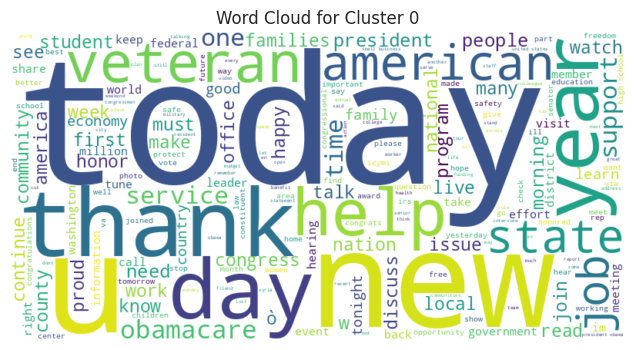

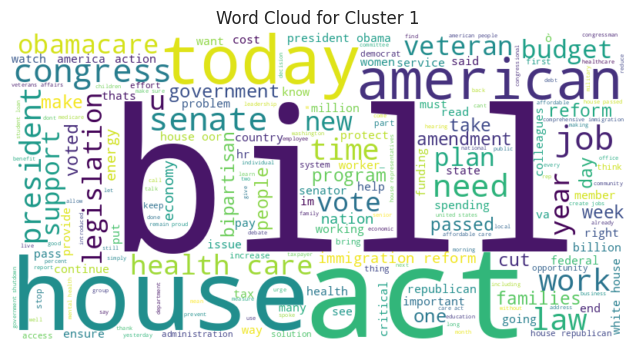

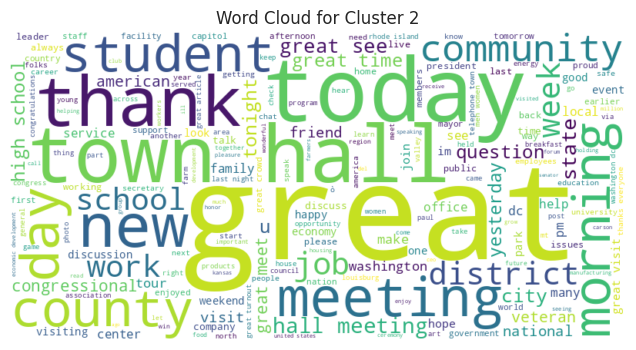

In [ ]:
# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(ml_df['TEXT'])

# Apply K-Means clustering to find 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
ml_df['cluster'] = kmeans.fit_predict(X)

# Use PCA for dimensionality reduction to visualize clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

ml_df['pca1'] = X_pca[:, 0]
ml_df['pca2'] = X_pca[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue=ml_df['cluster'], palette='viridis', data=ml_df)
plt.title('Clustering of Political Tweets (K-Means + PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title="Cluster", labels=['Cluster 0', 'Cluster 1', 'Cluster 2'])
plt.show()

# Generate WordClouds for each cluster
for cluster in range(3):
    cluster_text = ' '.join(ml_df[ml_df['cluster'] == cluster]['TEXT'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster}')
    plt.show()

Okay so that definitely DID NOT work unc... Unless it did and we just need to look at it in 3 dimensions.
I am going to attempt zero-shot classification. basically i just have facebooks bart come in and reclassify the data for us with its smart little ai brain into 3 groups ('neutral, 'left', and 'right'). and my 2019 macbook has an Intel i5!!! I dont think this will ever finish running.

In [ ]:
# Initialize the zero-shot classification pipeline using bart
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
# Same as the code below except this code doesnt give a confidence score of the predicted label. I think a confidence score would be nice so maybe dont run this cell.

# Define candidate labels for classification
candidate_labels = ["left", "neutral", "right"]

# Function to classify a single tweet
def classify_text(text):
    result = classifier(text, candidate_labels=candidate_labels)
    return result['labels'][0]  # The highest scoring label

# Apply the classification function to the 'TEXT' column
ml_df['PREDICTED_BIAS'] = ml_df['TEXT'].apply(classify_text)

# Display some sample results
print(ml_df[['TEXT', 'BIAS', 'PREDICTED_BIAS']].head())

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


ValueError: You must include at least one label and at least one sequence.

In [ ]:
# with confidence score

# Define candidate labels for classification
candidate_labels = ["left", "neutral", "right"]

# Function to get the confidence score of the predicted label
def classify_text_with_score(text):
    result = classifier(text, candidate_labels=candidate_labels)
    return pd.Series({'PREDICTED_BIAS': result['labels'][0], 'CONFIDENCE': result['scores'][0]})

# Apply classification and extract scores
ml_df[['PREDICTED_BIAS', 'CONFIDENCE']] = ml_df['TEXT'].apply(classify_text_with_score)

# Summary statistics of confidence scores
print("\nConfidence Score Summary:")
print(ml_df['CONFIDENCE'].describe())

# Plot distribution of confidence scores
plt.figure(figsize=(8,5))
sns.histplot(ml_df['CONFIDENCE'], bins=20, kde=True)
plt.title("Confidence Score Distribution")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.show()

I think this error occured because we have rows with no text in them. Still need to go back to data cleaning and fix that.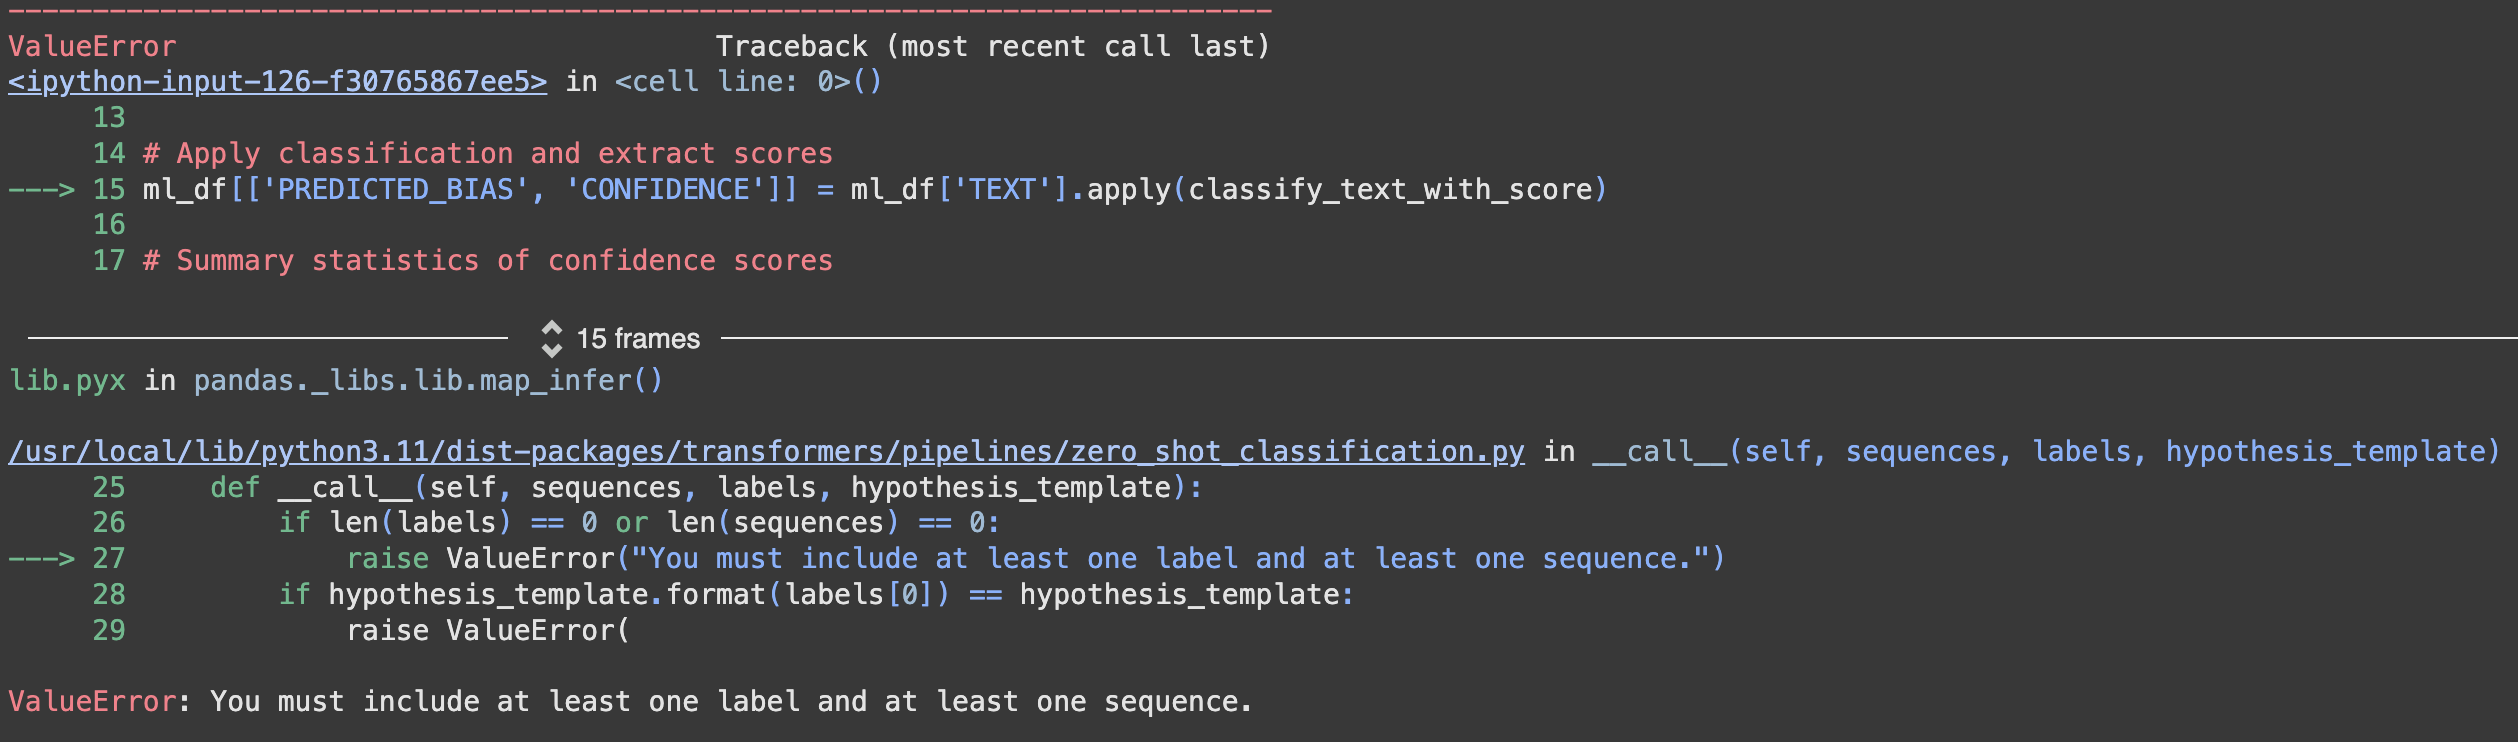




This code basically just makes a confusion matrix but I think it will kinda suck. All it really tells us is if the reclassification was able to effectively detect the 'partisan' rows and classify them as either 'right' or 'left', and the 'neutral' rows as 'neutral'. I dont really know how confusion matrices work but it cant be that confusing right. haha guys do u get it.

In [ ]:
# Convert actual and predicted labels to numeric values
label_mapping = {'neutral': 0, 'partisan': 1}
ml_df['BIAS_NUM'] = ml_df['BIAS'].map(label_mapping)
ml_df['PREDICTED_BIAS_NUM'] = ml_df['PREDICTED_BIAS'].replace({'left': 'partisan', 'right': 'partisan', 'neutral': 'neutral'}).map(label_mapping)

# Generate the confusion matrix
conf_matrix = confusion_matrix(ml_df['BIAS_NUM'], ml_df['PREDICTED_BIAS_NUM'])

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Neutral vs Partisan)")
plt.show()

# Print classification report
print("Classification Report:\n")
print(classification_report(ml_df['BIAS_NUM'], ml_df['PREDICTED_BIAS_NUM'], target_names=label_mapping.keys()))


KeyError: 'PREDICTED_BIAS'

In [ ]:
!pip install transformers torch

Here is our official machine learning model, RoBERTa from hugging face. Now, let's get ready to rumbleeeeeeeeeeeeeee

# DeepSeek Model

In [ ]:
!curl -fsSL https://ollama.sh | sh

curl: (28) Failed to connect to ollama.sh port 443 after 129111 ms: Connection timed out


In [ ]:
!pip install ollama

In [ ]:
import subprocess
subprocess.Popen("ollama serve", shell = True)

<Popen: returncode: None args: 'ollama serve'>

In [ ]:
!ollama run deepseek-coder-v2

/bin/bash: line 1: ollama: command not found


In [ ]:
subprocess.Popen("ollama sere", shell = True)

<Popen: returncode: None args: 'ollama sere'>

In [ ]:
import ollama

response = ollama.chat(
    model='deepseek-coder-v2',
    messages=[
        {
            'role': 'user',
            'content': 'Why is the sky blue?',
        }
    ]
)
print(response['message']['content'])

ConnectionError: Failed to connect to Ollama. Please check that Ollama is downloaded, running and accessible. https://ollama.com/download

MINH'S ATTEMPT AT INSTALLING DEEPSEEK AI https://www.youtube.com/watch?v=bZKCoJDSo9g

In [ ]:
#!pip install transformers==4.48.0
#!pip install --upgrade torch

In [ ]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 838.4/838.4 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 101.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install transformers torch #run once per session

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from transformers import pipeline

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import AutoModel

In [ ]:
import torch

In [ ]:
import torch.nn as nn

In [ ]:
class CustomClassifier(nn.Module):
    def __init__(self, model_name, num_classes=3):
        super().__init__()
        self.base_model = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.base_model.config.hidden_size, num_classes)  # Convert output to 3 classes

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use CLS token embedding
        logits = self.classifier(pooled_output)  # Convert to 3 class logits
        return logits

In [ ]:
!pip install huggingface_hub

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read)

In [ ]:
model = CustomClassifier("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B")

In [ ]:
# Example text for classification
text = "I love Donald Trump, MAGA"

# Tokenize the input text
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B")
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

In [ ]:
labels = ["Right-Wing", "Neutral", "Left-Wing"]
# Get the logits
logits = model(inputs["input_ids"], inputs["attention_mask"])

# Convert logits to probabilities using softmax
predictions = torch.softmax(logits, dim=1)

# Get the predicted class
predicted_class = torch.argmax(predictions, dim=1).item()

# Labels list
labels = ["Right-Wing", "Neutral", "Left-Wing"]
predicted_label = labels[predicted_class]
print(f"Predicted label: {predicted_label}")

In [ ]:
# Load the text classification pipeline
classifier = pipeline("text-classification", model="deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B")

# Perform classification
result = classifier(text)

# Print the result
print(result)

In [ ]:
# List of texts
texts = [
    "I love using Google Colab!",
    "This is the worst experience ever.",
    "The product is okay, not great."
]

# Perform classification on multiple texts
results = classifier(texts)

# Print the results
for text, result in zip(texts, results):
    print(f"Text: {text}\nLabel: {result['label']}, Confidence: {result['score']:.4f}\n")

NameError: name 'classifier' is not defined